In [1]:
import pandas as pd
import numpy as np
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import numpy as np

- Reading the data

In [2]:
data = pd.read_csv("cookie_cats.csv")

# Goal
- Cookie Cats is a puzzle game designed for mobile devices. As players advance through the game, they will encounter checkpoints (referred to as gates) that introduce a waiting period or present the option for in-app purchases before progression is allowed. The objective of this project is to assess the outcomes of an A/B test conducted on Cookie Cats, involving the relocation of the initial gate from level 30 to level 40. Our primary emphasis will be on investigating the effects of this modification on player retention and the number of game rounds played.

## Data

- __userid:__ unique number for player identification
- __version:__ whether player plays the control group (gate at level 30) or the test group (gate at level 40)
- __sum_gamerounds:__ the number of games player played during the first week after installation
- __retention_1:__ whether player plays the game 1 day after installation
- __retention_7:__ whether player plays the game 7 day after installation

# Summary

- We performed A/B testing based on 3 features:
    - sum_gamerounds
    - retention_1
    - retention_7
- To check the normality of distributions for both control group and test group, we performed Shapiro test which is based on following hypothesis:

    - __H0:__ Data distribution is normal
    - __H1:__ Data distribution is not normal
    
    
    
- Shapiro test reject the normality assumption of all three features for both groups. We employed a non-parametric test, specifically the Mann-Whitney U test, to compare the two groups.

    - __H0:__ control version and test version are similar
    - __H1:__ control version and test version are not similar 
    
    
- __sum_gamerounds__ and __retention_1__
    - Based on the Mann-Whitney U test result, we failed to reject null hypothesis and there are not statistically significant difference between two groups about moving first gate from level 30 to level 40 for game rounds.
    
- __retention_7__
    - Based on the Mann-Whitney U test result, we reject null hypothesis and there are statistically significant difference between two groups about moving first gate from level 30 to level 40 for game rounds.
    - Upon examining the distribution plots of both the control and test groups, it became evident that the likelihood of retention_7 being higher in the control group compared to the test group is 99.8%. Based on compelling evidence, we can conclude that the 7-day retention rate is notably higher when the gate is positioned at level 30 as opposed to level 40. 
    

In [3]:
data.head(3)

userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False

- Half of the users play fewer than 16 game rounds during the first week after installing the game. 
- 75% of users played less than 51 rounds during the first week.
- Almost 4000 users did not even play one round during the first week.

In [4]:
data[["sum_gamerounds"]].describe(percentiles=[.25,.5,.75,.85,.95,.99]).T

count       mean         std  min  25%   50%   75%   85%  \
sum_gamerounds  90189.0  51.872457  195.050858  0.0  5.0  16.0  51.0  92.0   

                  95%    99%      max  
sum_gamerounds  221.0  493.0  49854.0

In [5]:
data[data["sum_gamerounds"]==0]["userid"].count()

3994

- Since players randomly assigned to each version, the control group and the test group have approximately equal numbers of players.

In [7]:
(
 data["version"]
 .value_counts(normalize=True)
 .to_frame()
 .style.set_caption("Percentage of users in control version and test version" )
 .format("{:.1%}")
)

- There is no missing value in the dataset.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


- Based on the results, test group has a sligthly lower Game round played. 

In [16]:
(
 data
 .groupby("version")["sum_gamerounds"]
 .describe()
 .style.set_caption("sum_gamerounds aggregation" )
 .format("{:.1f}")
 .format("{:,.0f}", subset = ["count"])

)

- The provided boxplot displays the "sum_gamerounds" variable, indicating the number of games played by players within the initial week of installation. To improve the visibility of the other values on the plot, the top 0.1 percentile has been omitted.

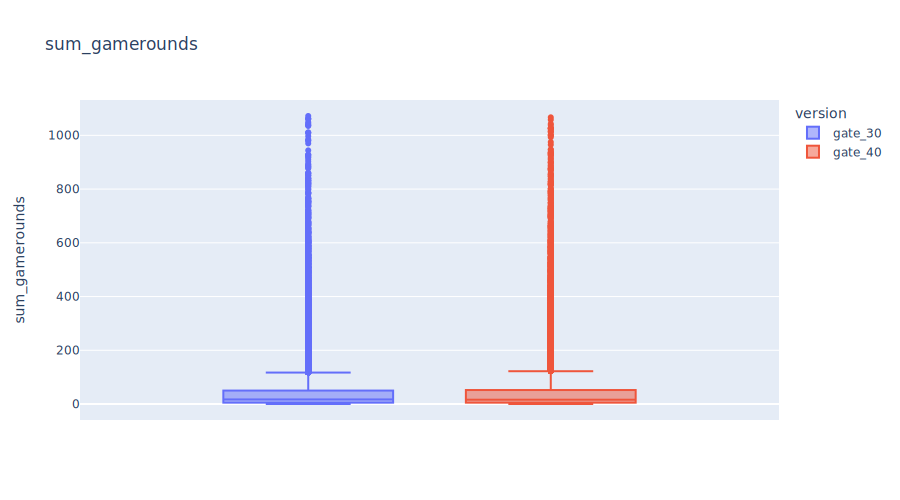

In [21]:
df = data[data["sum_gamerounds"]<data["sum_gamerounds"].quantile(.999)]

fig = px.box(df, y = "sum_gamerounds",color="version", title = "sum_gamerounds")
fig.update_layout(height = 500, width = 900)
fig.update_yaxes(title = "sum_gamerounds")
fig.show("svg")

- Both groups have a skewed distribution, meanig that number of players with high number of plays in the first week is very low.

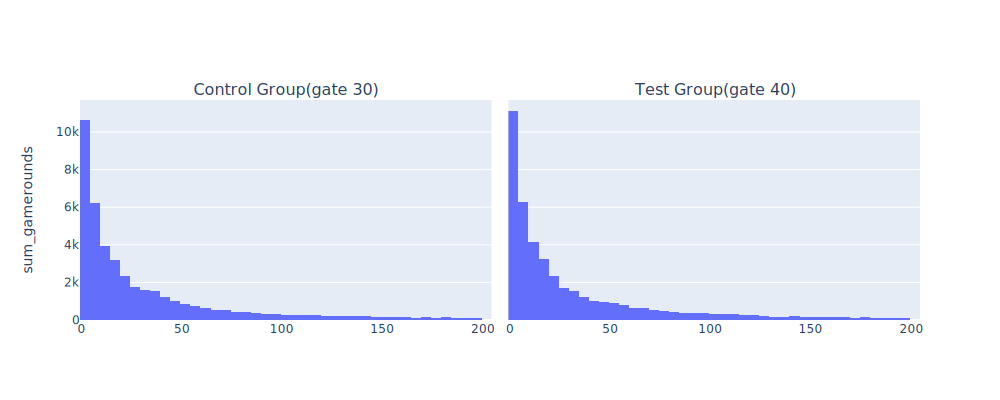

In [22]:
filt_200 = df["sum_gamerounds"]<=200
fig = make_subplots(rows =1, cols = 2, shared_yaxes=True, horizontal_spacing=.02, subplot_titles=["Control Group(gate 30)","Test Group(gate 40)"])
fig.add_traces(px.histogram(df[(df["version"]=="gate_30") & (filt_200)] , x="sum_gamerounds" ,  nbins=70, title = "sum_gamerounds")["data"], rows = 1,cols = 1)
fig.add_traces(px.histogram(df[(df["version"]=="gate_40") & (filt_200)] , x="sum_gamerounds",  nbins=70)["data"], rows = 1, cols = 2)

fig.update_layout(height = 400, width = 1000)
fig.update_yaxes(title = "sum_gamerounds", col = 1)
fig.show("svg")

- Based on following cell, 55.2% and 81.0% of users in control version plays 1 day and 7 day after installing the game.
- Based on following cell, 55.8% and 81.8% of users in test version plays 1 day and 7 day after installing the game.

In [12]:
df_retention = pd.DataFrame({"Retention_1_ratio": data.groupby("version")["retention_1"].value_counts(normalize = True),
              "Retention_7_ratio":  data.groupby("version")["retention_7"].value_counts(normalize = True)}).reset_index()

(
    df_retention
    .style.set_caption("Retention Percentage by Game Version" )
#     .hide([row for row in df_retention.index if df_retention.loc[row]["level_1"]==False], axis=0)
    .format(precision=3)
)

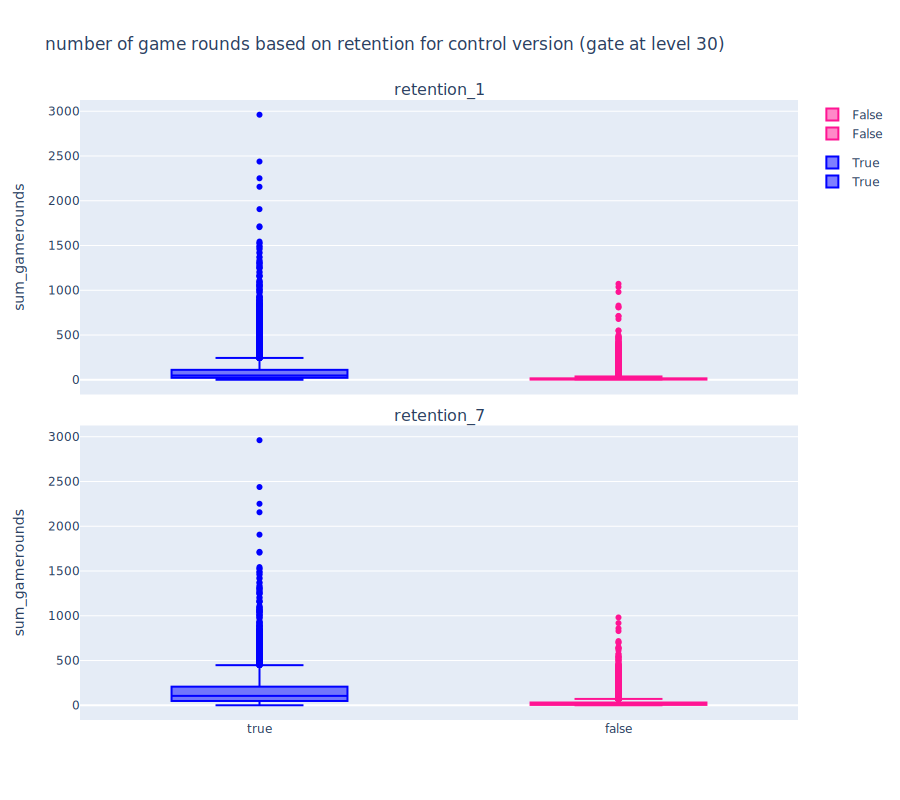

In [13]:
df = data[data["sum_gamerounds"]<data["sum_gamerounds"].max()]
color_discrete_map = {True: 'blue', False: 'deeppink'}

df_30 = df[df["version"]=="gate_30"]

fig = make_subplots(rows=2, cols=1, subplot_titles=["retention_1","retention_7"], vertical_spacing=.05,shared_xaxes=True )
fig.add_traces(px.box(df_30, x="retention_1", y = "sum_gamerounds",
                      color="retention_1",color_discrete_map=color_discrete_map, title = "sum_gamerounds")["data"], rows=1, cols = 1)
fig.add_traces(px.box(df_30,  x="retention_7",y = "sum_gamerounds",
                      color="retention_7",color_discrete_map=color_discrete_map,title = "sum_gamerounds")["data"], rows=2, cols = 1)

fig.update_layout(height = 800, width = 900, title = "number of game rounds based on retention for control version (gate at level 30)")
fig.update_yaxes(title = "sum_gamerounds")
fig.update_xaxes(categoryarray = [True,False])
fig.show("svg")

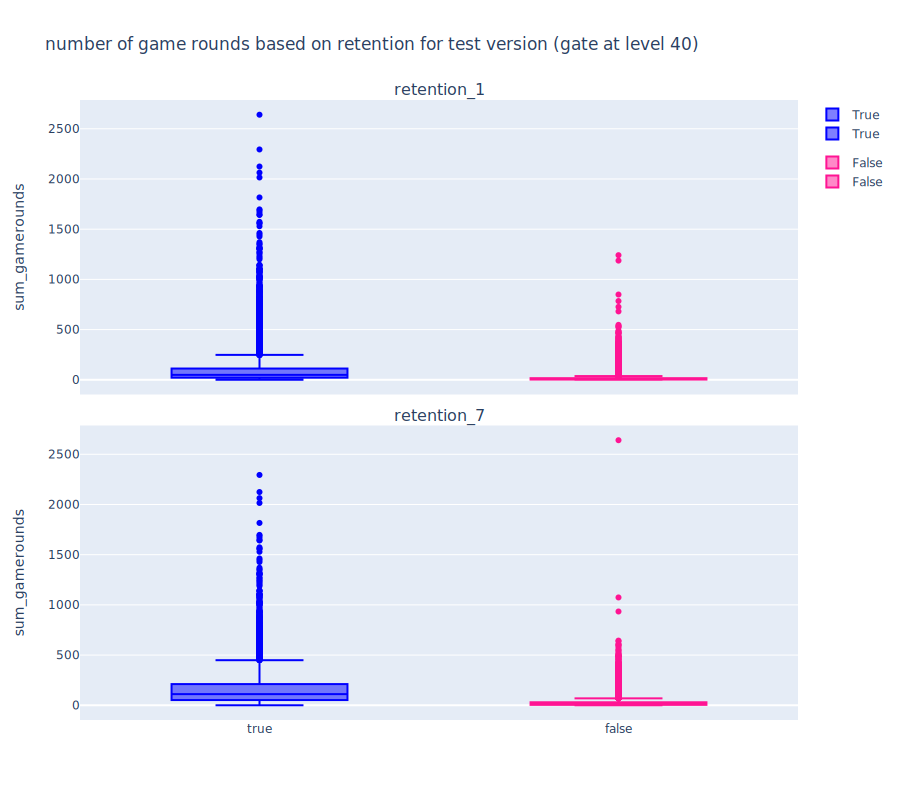

In [14]:
df_40 = df[df["version"]=="gate_40"]
color_discrete_map = {True: 'blue', False: 'deeppink'}

fig = make_subplots(rows=2, cols=1, subplot_titles=["retention_1","retention_7"], vertical_spacing=.05,shared_xaxes=True )
fig.add_traces(px.box(df_40, x="retention_1", y = "sum_gamerounds",
                      color="retention_1", color_discrete_map=color_discrete_map , title = "sum_gamerounds")["data"], rows=1, cols = 1)
fig.add_traces(px.box(df_40,  x="retention_7",y = "sum_gamerounds",
                      color="retention_7", color_discrete_map=color_discrete_map,title = "sum_gamerounds")["data"], rows=2, cols = 1)

fig.update_layout(height = 800, width = 900, title = "number of game rounds based on retention for test version (gate at level 40)")
fig.update_yaxes(title = "sum_gamerounds")
fig.show("svg")

- Checking game rounds played grouping by retention after 1 day and retention after 7 days.

In [30]:
(
    data.groupby(["version","retention_1"])["sum_gamerounds"]
    .describe()
    .style.format("{:.1f}")
    .format("{:,.0f}", subset = ["count"])
    )


In [31]:
(
    data.groupby(["version","retention_7"])["sum_gamerounds"]
    .describe()
    .style.format("{:.1f}")
    .format("{:,.0f}", subset = ["count"])
    )

# Analysis

- Following function is defined based on steps mentioned above.

In [34]:
def AB_testing_func(df, ab, value):
    
    #packages
    import scipy.stats as stats
    import pandas as pd
    import warnings
    warnings.simplefilter(action='ignore')
    
    #define control and test groups
    group_A = df[df[ab]=="gate_30"][value]
    group_B = df[df[ab]=="gate_40"][value]  
    
    #Normality check
        # H0: Data distribution is normal
        # H1: Data distribution is not normal
        
    res_A = stats.shapiro(group_A)
    res_B = stats.shapiro(group_B)
    
    normality_A = res_A[1] > 0.05
    normality_B = res_B[1] > 0.05
    
    
    # if we have normal distribution meaning that the null hypothesis is True:
        # we can go a head and check for homogeneity of variances using levene test:
        
    # Parametric Test
    if (normality_A == True) & (normality_B == True):  
        test_type = "Parametric"
        
        # homogeneity of variances
        # H0:all input samples are from populations with equal variance
        # H1: Data distribution is not normal
        levene_res = stats.levene(group_A, group_B)
        homo = leven_res[1] > 0.05
        
        
        if homo== True:
            
            
            # H0: 2 independent samples have identical average
            # H1: 2 independent samples don't have identical average
            '''equal_var: If True (default), perform a standard independent 2 sample test that
               assumes equal population variances. 
               If False, perform Welch’s t-test, which does not assume equal population variance
            '''
            test = "ttest_ind"
            final_res = stats.ttest_ind(group_A, group_B, equal_var=True)
    
        else:
            test = "Welch’s t-test"
            final_res = stats.ttest_ind(group_A, group_B, equal_var=False)
    
    # Non_Parametric Test
    else:
        test_type = "Non_Parametric"
        test = "mannwhitneyu"
        final_res = stats.mannwhitneyu(group_A, group_B)
        
    result = pd.DataFrame(columns=["Test_Type","Test", "AB Hypohthesis", "p_value", "detail" ])
    result.loc[0, "Test_Type"]= test_type
    result.loc[0, "Test"]= test

    result.loc[0, "AB Hypohthesis"]=  ["reject H0" if final_res[1]<0.05 else "fail to reject H0"][0]
    result.loc[0, "p_value"]= round(final_res[1],4)
    result.loc[0, "detail"]= ["control group and test group are not similar" if final_res[1]<0.05 else "control group and test group are similar"][0]
    
    
    if test_type == "Parametric":
        result.loc[0, "control version normality"]= normality_A
        result.loc[0, "test version normality"]= normality_B
        
        result.loc[0, "homogeneity of variances"]= levene_res[1]
    
    
    #prints
    
    print("--------------------------------")
    print("\033[1m" + "Normality"  + "\033[0m")
    normality_str_A = f'Normality of control group (gate_30)\ntest statistic: {round(res_A[0],3)}      test p_value{round(res_A[1],3)} ' 
    print(normality_str_A)
    print("\n")
    normality_str_B = f'Normality of test group (gate_40)\ntest statistic: {round(res_B[0],3)}      test p_value{round(res_B[1],3)} ' 
    print(normality_str_B)
    if (normality_A == True) & (normality_B == True):  
        print("--------------------------------")    
        print("\033[1m" + "homogeneity of variances "  + "\033[0m")
        homo_str = f'test statistic: {round(levene_res[0],3)}      test p_value{round(levene_res[1],3)} ' 
        print(homo_str)
        
    
    print("--------------------------------")    
    print("\033[1m" + "AB Test"  + "\033[0m")
    f_str = 'H0: control version and test version are similar\nH1: control version and test version are not similar '
    print("\033[1m" + f_str  + "\033[0m")
    
    final_str = f'test statistic: {round(final_res[0],3)}      test p_value{round(final_res[1],4)} ' 
    print(final_str)
    print("\n")

    if final_res[1] > 0.05:
        f_final = "There is no statistically significant difference between both groups."
    else:
        f_final = "Groups are statistically significant."
        
    print(f_final)
    
    return result
        

In [38]:
AB_testing_func(df, ab= "version", value = "sum_gamerounds")

--------------------------------
Normality
Normality of control group (gate_30)
test statistic: 0.541      test p_value0.0 


Normality of test group (gate_40)
test statistic: 0.539      test p_value0.0 
--------------------------------
AB Test
H0: control version and test version are similar
H1: control version and test version are not similar 
test statistic: 1022467119.5      test p_value0.0446 


Groups are statistically significant.


Test_Type          Test AB Hypohthesis p_value  \
0  Non_Parametric  mannwhitneyu      reject H0  0.0446   

                                         detail  
0  control group and test group are not similar

In [39]:
AB_testing_func(df, ab= "version", value = "retention_1")

--------------------------------
Normality
Normality of control group (gate_30)
test statistic: 0.633      test p_value0.0 


Normality of test group (gate_40)
test statistic: 0.632      test p_value0.0 
--------------------------------
AB Test
H0: control version and test version are similar
H1: control version and test version are not similar 
test statistic: 1020708439.0      test p_value0.0704 


There is no statistically significant difference between both groups.


Test_Type          Test     AB Hypohthesis p_value  \
0  Non_Parametric  mannwhitneyu  fail to reject H0  0.0704   

                                     detail  
0  control group and test group are similar

In [40]:
AB_testing_func(df, ab= "version", value = "retention_7")

--------------------------------
Normality
Normality of control group (gate_30)
test statistic: 0.478      test p_value0.0 


Normality of test group (gate_40)
test statistic: 0.468      test p_value0.0 
--------------------------------
AB Test
H0: control version and test version are similar
H1: control version and test version are not similar 
test statistic: 1023065725.5      test p_value0.0013 


Groups are statistically significant.


Test_Type          Test AB Hypohthesis p_value  \
0  Non_Parametric  mannwhitneyu      reject H0  0.0013   

                                         detail  
0  control group and test group are not similar